In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
import importlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import Temperature_Pipeline as TP

importlib.reload(TP)

<module 'Temperature_Pipeline' from 'C:\\Users\\sebas\\PycharmProjects\\Advanced-Lab-Code\\Temperature Runs\\Temperature_Pipeline.py'>

In [2]:
file = "Temperature_Runs.xlsx"
sheets = ["77.4","112","147","182","217"]
cols = [
    ["77_0", "77_1"],
    ["112_0", "112_1"],
    ["147_0", "147_1"],
    ["182_0", "182_1"],
    ["217_0", "217_1"]
]

start_index = 9830

padding = [164, 225]

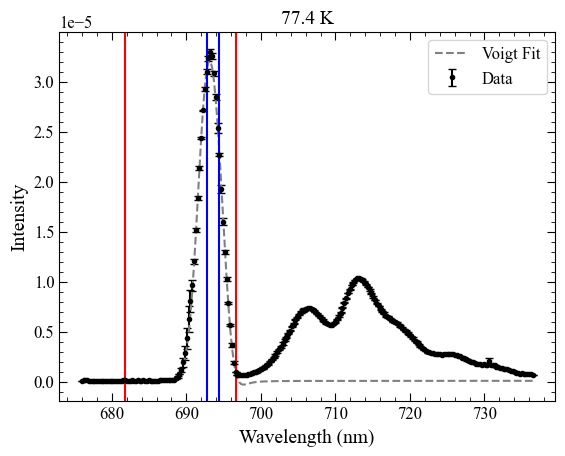

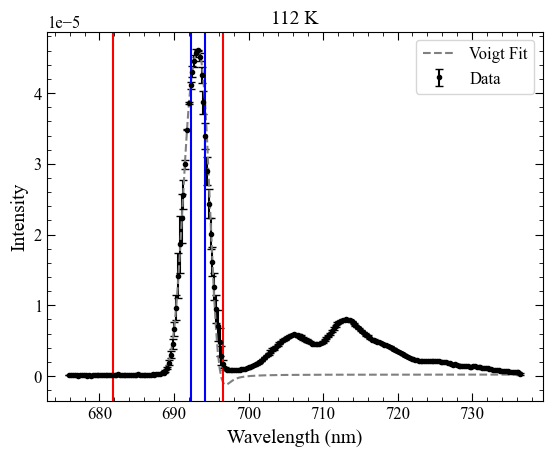

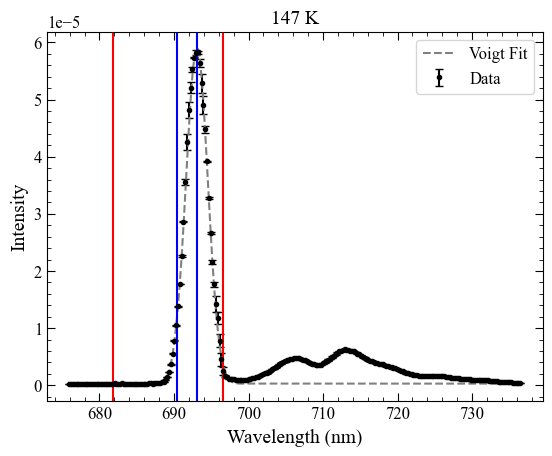

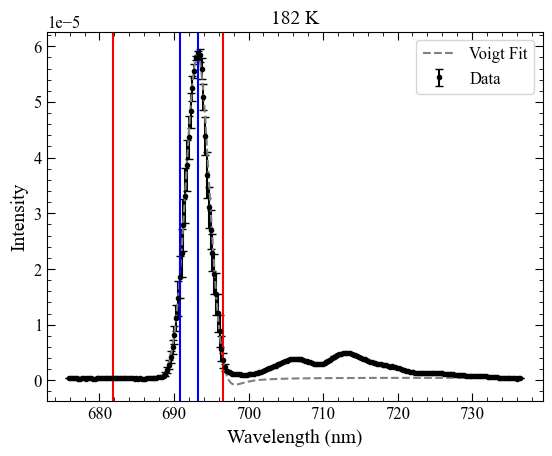

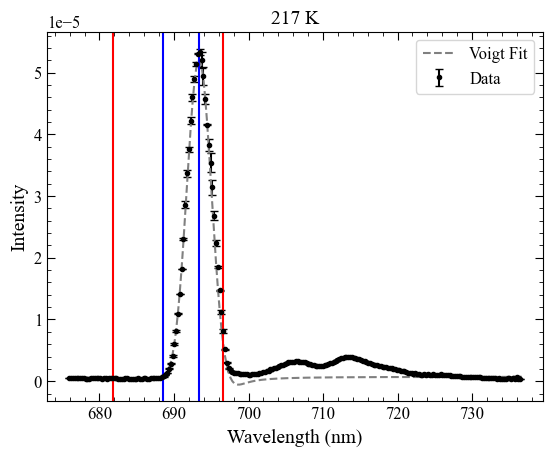

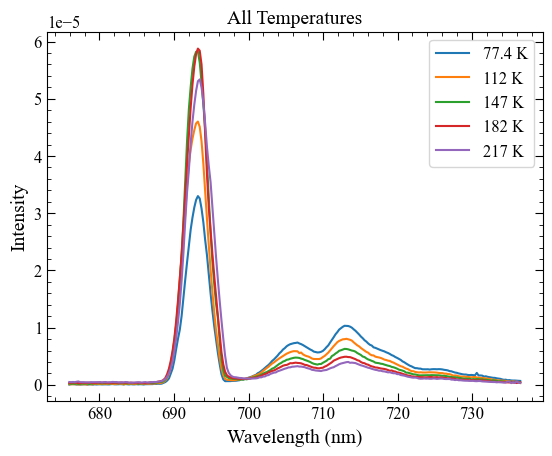

   Temperature     Center1  Center1_err     Center2  Center2_err     Sigma  \
0         77.4  692.739815     0.041938  694.439462     0.051173  1.238602   
1        112.0  692.273481     0.067407  694.094535     0.063768  1.155381   
2        147.0  690.356660     0.026245  693.070735     0.002082  1.469516   
3        182.0  690.854908     1.159143  693.189111     0.064343  1.728823   
4        217.0  688.513784     0.069784  693.367540     0.001755  1.815567   

   Sigma_err    Gamma1    Gamma2  Reduced_Chi2  
0   0.013474  0.120669 -0.636289     41.588199  
1   0.021551  0.116528 -0.634444     24.933863  
2   0.001713 -4.320106 -0.006959     17.381499  
3   0.105838  1.450941 -0.493667      8.516182  
4   0.008516 -0.125290 -0.495295    122.715233  


In [3]:
wavelengths, table = TP.run_pipeline_all_temperatures(
    file,
    sheets,
    cols,
    start_index,
    padding,
    plot=True
)

print(table)

In [4]:
T_data = table["Temperature"].to_numpy()
R2_data = table["Center1"].to_numpy()
R2_error = table["Center1_err"].to_numpy()

R1_data = table["Center2"].to_numpy()
R1_error = table["Center2_err"].to_numpy()

In [5]:
from scipy.integrate import quad

def debye_integrand(x):
    return x**3 / (np.exp(x) - 1)

def debye_integral(T, Td):

    if T <= 0:
        return 0  # avoid divide by zero

    upper = min(Td/T, 50)

    result, _ = quad(
        lambda x: x**3/(np.exp(x)-1),
        0,
        upper
    )

    return result

def ruby_shift_model(T, R0, alpha, Td):
    integral_vals = np.array([debye_integral(t, Td) for t in T])
    return R0 + alpha * (T / Td)**4 * integral_vals

p0_R1 = [R1_data[0], 1.0, 400]  # Initial guesses

popt_R1, pcov_R1 = curve_fit(
    ruby_shift_model,
    T_data,
    R1_data,
    sigma=R1_error,        # optional
    absolute_sigma=True,  # optional
    p0=p0_R1
)

R0_fit_R1, alpha_fit_R1, Td_fit_R1 = popt_R1
errors_R1 = np.sqrt(np.diag(pcov_R1))

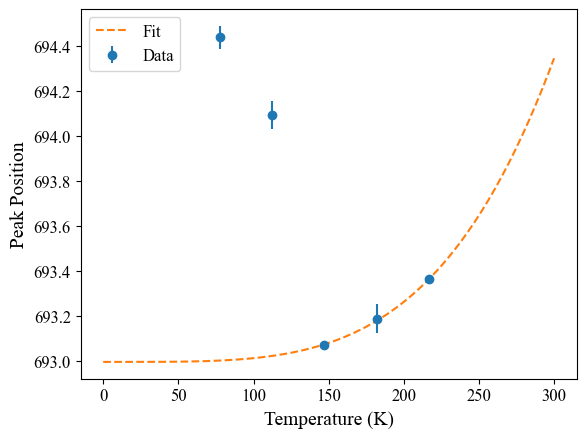

In [6]:
T_fit = np.linspace(0, 300, 200)
R_fit_R1 = ruby_shift_model(T_fit, *popt_R1)

plt.errorbar(T_data, R1_data, yerr=R1_error, fmt='o', label="Data")
plt.plot(T_fit, R_fit_R1, '--', label="Fit")

plt.xlabel("Temperature (K)")
plt.ylabel("Peak Position")
plt.legend()
plt.show()

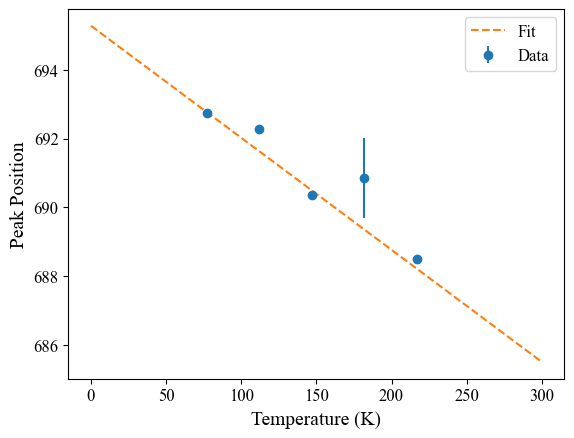

In [11]:
p0_R2 = [R2_data[0], 1.0, 400]  # Initial guesses

popt_R2, pcov_R2 = curve_fit(
    ruby_shift_model,
    T_data,
    R2_data,
    sigma=R2_error,  # optional
    absolute_sigma=True,  # optional
    p0=p0_R2
)

R0_fit_R2, alpha_fit_R2, Td_fit_R2 = popt_R2
errors_R2 = np.sqrt(np.diag(pcov_R2))
T_fit = np.linspace(0, 300, 200)
R_fit_R2 = ruby_shift_model(T_fit, *popt_R2)

plt.errorbar(T_data, R2_data, yerr=R2_error, fmt='o', label="Data")
plt.plot(T_fit, R_fit_R2, '--', label="Fit")

plt.xlabel("Temperature (K)")
plt.ylabel("Peak Position")
plt.legend()
plt.show()

In [15]:
Td_fixed = 760

def ruby_shift_model_fixed(T, R0, alpha):
    integral_vals = np.array([debye_integral(t, Td_fixed) for t in T])
    return R0 + alpha * (T / Td_fixed)**4 * integral_vals

popt, pcov = curve_fit(
    ruby_shift_model_fixed,
    T_data,
    R2_data,
    p0=[R2_data[0], 1.0]
)

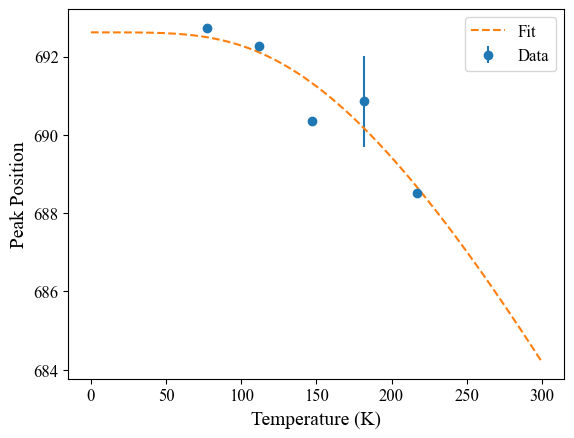

In [16]:
plt.figure(1)
plt.errorbar(T_data, R2_data, yerr=R2_error, fmt='o', label="Data")
plt.plot(T_fit, ruby_shift_model_fixed(T_fit, *popt), '--', label="Fit")
plt.xlabel("Temperature (K)")
plt.ylabel("Peak Position")
plt.legend()
plt.show()

In [17]:
print(popt[0])
print(popt[1])

692.6177930684797
-183.36059626171303
